### Plotting Test
Alex is using this Jupyter notebook to test the plotting + print statements from query.py.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from lsst.rsp import get_tap_service
import query as q

In [2]:
# testing with NEOs
query = q.make_query(q_cutoff=1.3, a_cutoff_min=4.0, e_cutoff = 1.0)
print(query)

SELECT incl, q, e FROM dp03_catalogs_10yr.MPCORB as mpc
            WHERE mpc.q < 1.3 AND mpc.e < 1.0 AND mpc.q/(1-mpc.e) > 4.0;


In [3]:
# running the query
NEO_objects_table = q.run_query(query)

Job phase is COMPLETED
       incl                q                  e         
       deg                 AU                           
------------------ ------------------ ------------------
 31.09252999999999 1.2431035093273948 0.7084432623285193
 19.65134000000001 0.9203771729951332 0.9482300675541342
11.950449999999982 1.2044032778498057 0.7171247011872852
20.647300000000012 0.9577024708382867 0.9221009097705802
17.385910000000003 1.1049621973607813  0.779217861775766


In [4]:
a = q.calc_semimajor_axis(NEO_objects_table['q'], NEO_objects_table['e'])
NEO_objects_table['a'] = a
print(NEO_objects_table[0:5]) # print first few rows 

       incl                q                  e                  a         
       deg                 AU                                              
------------------ ------------------ ------------------ ------------------
 31.09252999999999 1.2431035093273948 0.7084432623285193  4.263676151871663
 19.65134000000001 0.9203771729951332 0.9482300675541342 17.778218543312622
11.950449999999982 1.2044032778498057 0.7171247011872852  4.257718093113579
20.647300000000012 0.9577024708382867 0.9221009097705802 12.294141921526524
17.385910000000003 1.1049621973607813  0.779217861775766  5.004762641797333


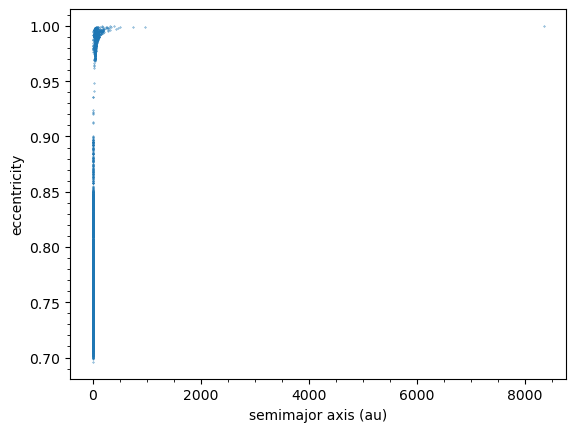

In [5]:
fig, ax = plt.subplots()
    # plt.xlim([0., 4.])
    # plt.ylim([0., 1.])
ax.scatter(NEO_objects_table['a'], NEO_objects_table['e'], s=0.1) # a vs. e
ax.set_xlabel('semimajor axis (au)')
ax.set_ylabel('eccentricity')
ax.minorticks_on()
plt.show()

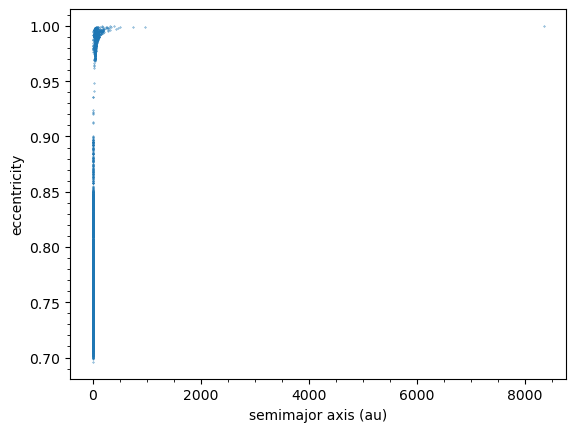

In [6]:
q.plot_data(NEO_objects_table, "a", "e", 'semimajor axis (au)', 'eccentricity')
